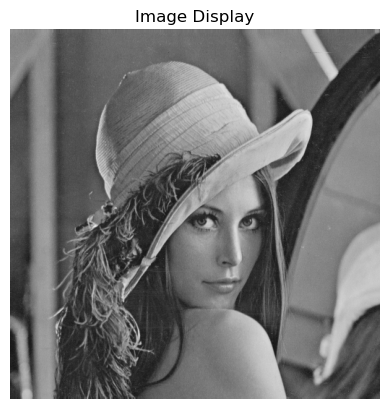

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "./image/lena_grey.bmp"
img = cv2.imread(image_path, 0)

# Ensure the image was loaded successfully
if img is not None:
    # Convert image from BGR (OpenCV format) to RGB (Matplo`tlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.title('Image Display')
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("Error: Could not load the image.")


<BarContainer object of 256 artists>

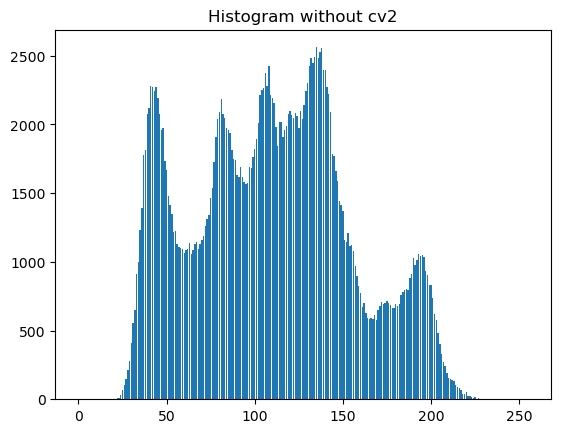

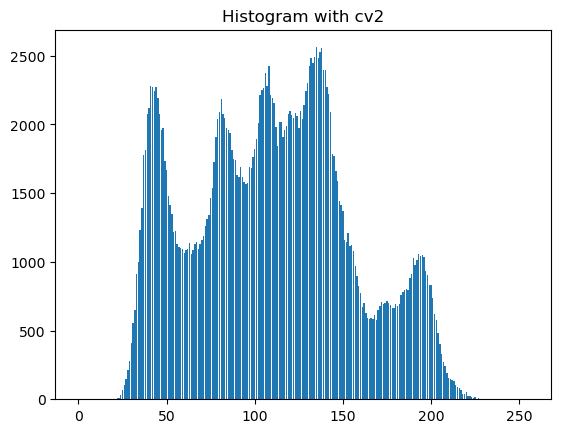

In [38]:
# Draw Histogram without cv2
h, w = img.shape[:2]
histogram = np.zeros(256)

for j in range(h):
    for i in range(w):
        histogram[img[j,i]] += 1

x = np.arange(256)

plt.figure(1)
plt.title("Histogram without cv2")
plt.bar(x, histogram)

# Draw Histogram with cv2

histogram = cv2.calcHist([img], [0], None, [256], [0,256])

plt.figure(2)
plt.title("Histogram with cv2")
plt.bar(x, histogram.ravel())